In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Libraries

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import holidays
from sklearn.preprocessing import LabelEncoder
import warnings
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.metrics import mean_squared_error


# Load the LCL dataset

In [65]:
# Load the LCL dataset
LCL_df = pd.read_csv('/content/drive/MyDrive/Low Carbon dataset/LCL-June2015v2_0.csv')

In [19]:
LCL_df

,LCLid,stdorToU,DateTime,KWH/hh (per half hour)
0,MAC000002,Std,2012-10-12 00:30:00.0000000,0
1,MAC000002,Std,2012-10-12 01:00:00.0000000,0
2,MAC000002,Std,2012-10-12 01:30:00.0000000,0
3,MAC000002,Std,2012-10-12 02:00:00.0000000,0
4,MAC000002,Std,2012-10-12 02:30:00.0000000,0
...,...,...,...,...
999995,MAC000036,Std,2012-11-08 08:00:00.0000000,0.228
999996,MAC000036,Std,2012-11-08 08:30:00.0000000,0.042
999997,MAC000036,Std,2012-11-08 09:00:00.0000000,0.076
999998,MAC000036,Std,2012-11-08 09:30:00.0000000,0.07


In [66]:
# Strip leading/trailing spaces from column names
LCL_df.columns = LCL_df.columns.str.strip()

# Convert DateTime column to datetime
LCL_df['DateTime'] = pd.to_datetime(LCL_df['DateTime'])

# Convert 'KWH/hh (per half hour)' column to numeric
LCL_df['KWH/hh (per half hour)'] = pd.to_numeric(LCL_df['KWH/hh (per half hour)'], errors='coerce')

# Statistic of the Data

In [21]:
LCL_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   LCLid                   1000000 non-null  object        
 1   stdorToU                1000000 non-null  object        
 2   DateTime                1000000 non-null  datetime64[ns]
 3   KWH/hh (per half hour)  999971 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 30.5+ MB


In [22]:
LCL_df.isnull().sum()

LCLid                      0
stdorToU                   0
DateTime                   0
KWH/hh (per half hour)    29
dtype: int64

In [23]:
LCL_df.describe()

,DateTime,KWH/hh (per half hour)
count,1000000,999971.000000
mean,2013-02-06 08:00:01.682613504,0.239580
min,2011-12-06 13:00:00,0.000000
25%,2012-08-06 16:00:00,0.060000
50%,2013-02-11 17:00:00,0.129000
75%,2013-08-16 15:30:00,0.255000
max,2014-02-28 00:00:00,6.528000
std,NaN,0.387533


# Pre-processing

## Extract Day and Month

In [71]:
LCL_df['Day'] = LCL_df['DateTime'].dt.day
LCL_df['Month'] = LCL_df['DateTime'].dt.month

In [72]:
LCL_df

,LCLid,stdorToU,DateTime,KWH/hh (per half hour),stdorToU_encoded,Day,Month
0,MAC000002,Std,2012-10-12 00:30:00,0.000,0,12,10
1,MAC000002,Std,2012-10-12 01:00:00,0.000,0,12,10
2,MAC000002,Std,2012-10-12 01:30:00,0.000,0,12,10
3,MAC000002,Std,2012-10-12 02:00:00,0.000,0,12,10
4,MAC000002,Std,2012-10-12 02:30:00,0.000,0,12,10
...,...,...,...,...,...,...,...
999995,MAC000036,Std,2012-11-08 08:00:00,0.228,0,8,11
999996,MAC000036,Std,2012-11-08 08:30:00,0.042,0,8,11
999997,MAC000036,Std,2012-11-08 09:00:00,0.076,0,8,11
999998,MAC000036,Std,2012-11-08 09:30:00,0.070,0,8,11


## Extract Season

In [73]:
# Define a function to map month to season
def get_season(month):
    if month in [12, 1, 2]:  # Winter: Dec, Jan, Feb
        return 'Winter'
    elif month in [3, 4, 5]:  # Spring: Mar, Apr, May
        return 'Spring'
    elif month in [6, 7, 8]:  # Summer: Jun, Jul, Aug
        return 'Summer'
    elif month in [9, 10, 11]:  # Autumn: Sep, Oct, Nov
        return 'Autumn'
    else:
        return 'Unknown'

# Apply the function to create 'Season' column
LCL_df['Season'] = LCL_df['Month'].apply(get_season)

In [76]:
LCL_df

,LCLid,stdorToU,DateTime,KWH/hh (per half hour),stdorToU_encoded,Day,Month,Season
0,MAC000002,Std,2012-10-12 00:30:00,0.000,0,12,10,Autumn
1,MAC000002,Std,2012-10-12 01:00:00,0.000,0,12,10,Autumn
2,MAC000002,Std,2012-10-12 01:30:00,0.000,0,12,10,Autumn
3,MAC000002,Std,2012-10-12 02:00:00,0.000,0,12,10,Autumn
4,MAC000002,Std,2012-10-12 02:30:00,0.000,0,12,10,Autumn
...,...,...,...,...,...,...,...,...
999995,MAC000036,Std,2012-11-08 08:00:00,0.228,0,8,11,Autumn
999996,MAC000036,Std,2012-11-08 08:30:00,0.042,0,8,11,Autumn
999997,MAC000036,Std,2012-11-08 09:00:00,0.076,0,8,11,Autumn
999998,MAC000036,Std,2012-11-08 09:30:00,0.070,0,8,11,Autumn


## Holidays

In [78]:
# Define UK holidays
uk_holidays = holidays.UK()

# Identify weekends (Saturday and Sunday)
LCL_df['is_weekend'] = LCL_df['DateTime'].dt.dayofweek.isin([5, 6])

# Identify holidays
LCL_df['is_holiday'] = LCL_df['DateTime'].apply(lambda x: x in uk_holidays)

# Identify working days (non-weekend weekdays that are not holidays)
LCL_df['is_working_day'] = ~LCL_df['is_weekend'] & ~LCL_df['is_holiday']


In [79]:
LCL_df

,LCLid,stdorToU,DateTime,KWH/hh (per half hour),stdorToU_encoded,Day,Month,Season,is_weekend,is_holiday,is_working_day
0,MAC000002,Std,2012-10-12 00:30:00,0.000,0,12,10,Autumn,False,False,True
1,MAC000002,Std,2012-10-12 01:00:00,0.000,0,12,10,Autumn,False,False,True
2,MAC000002,Std,2012-10-12 01:30:00,0.000,0,12,10,Autumn,False,False,True
3,MAC000002,Std,2012-10-12 02:00:00,0.000,0,12,10,Autumn,False,False,True
4,MAC000002,Std,2012-10-12 02:30:00,0.000,0,12,10,Autumn,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...
999995,MAC000036,Std,2012-11-08 08:00:00,0.228,0,8,11,Autumn,False,False,True
999996,MAC000036,Std,2012-11-08 08:30:00,0.042,0,8,11,Autumn,False,False,True
999997,MAC000036,Std,2012-11-08 09:00:00,0.076,0,8,11,Autumn,False,False,True
999998,MAC000036,Std,2012-11-08 09:30:00,0.070,0,8,11,Autumn,False,False,True


## Handling Missing Values

In [82]:
# Check for missing values
missing_values = LCL_df.isnull().sum()
missing_values

LCLid                     0
stdorToU                  0
DateTime                  0
KWH/hh (per half hour)    0
stdorToU_encoded          0
Day                       0
Month                     0
Season                    0
is_weekend                0
is_holiday                0
is_working_day            0
dtype: int64

In [83]:
# Drop rows with missing values
LCL_df = LCL_df.dropna()

LCL_df.isnull().sum()

LCLid                     0
stdorToU                  0
DateTime                  0
KWH/hh (per half hour)    0
stdorToU_encoded          0
Day                       0
Month                     0
Season                    0
is_weekend                0
is_holiday                0
is_working_day            0
dtype: int64

In [84]:
LCL_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 999971 entries, 0 to 999999
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   LCLid                   999971 non-null  category      
 1   stdorToU                999971 non-null  category      
 2   DateTime                999971 non-null  datetime64[ns]
 3   KWH/hh (per half hour)  999971 non-null  float64       
 4   stdorToU_encoded        999971 non-null  int64         
 5   Day                     999971 non-null  int32         
 6   Month                   999971 non-null  int32         
 7   Season                  999971 non-null  object        
 8   is_weekend              999971 non-null  bool          
 9   is_holiday              999971 non-null  bool          
 10  is_working_day          999971 non-null  bool          
dtypes: bool(3), category(2), datetime64[ns](1), float64(1), int32(2), int64(1), object(1)
memory usa

## Converting Data Types

In [69]:
# Convert columns to appropriate data types if necessary
LCL_df['LCLid'] = LCL_df['LCLid'].astype('category')
LCL_df['stdorToU'] = LCL_df['stdorToU'].astype('category')
LCL_df['KWH/hh (per half hour)'] = LCL_df['KWH/hh (per half hour)'].astype('float64')

# Display data types to verify
LCL_df.dtypes

LCLid                           category
stdorToU                        category
DateTime                  datetime64[ns]
KWH/hh (per half hour)           float64
dtype: object

# EDA

## Seasonal Energy Consumption

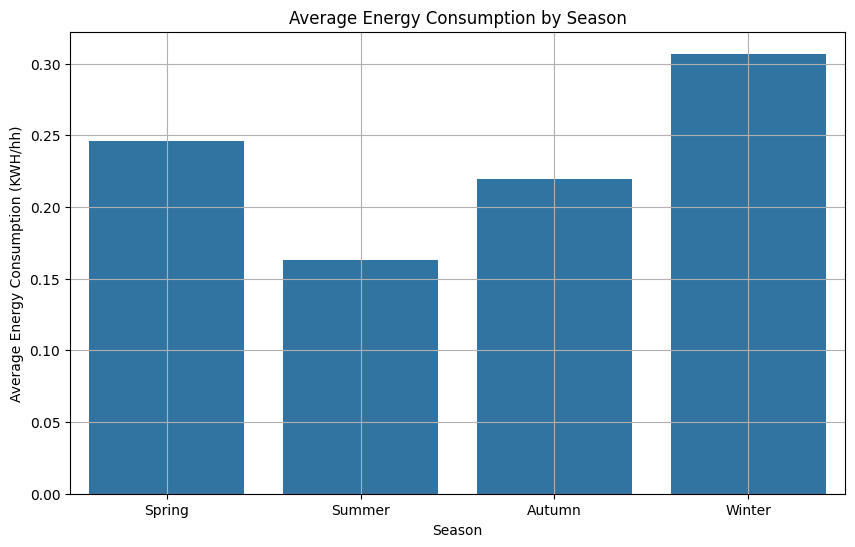

In [87]:
# Bar plot of average energy consumption by season
seasonal_avg = LCL_df.groupby('Season')['KWH/hh (per half hour)'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='Season', y='KWH/hh (per half hour)', data=seasonal_avg, order=['Spring', 'Summer', 'Autumn', 'Winter'])
plt.title('Average Energy Consumption by Season')
plt.xlabel('Season')
plt.ylabel('Average Energy Consumption (KWH/hh)')
plt.grid(True)
plt.show()


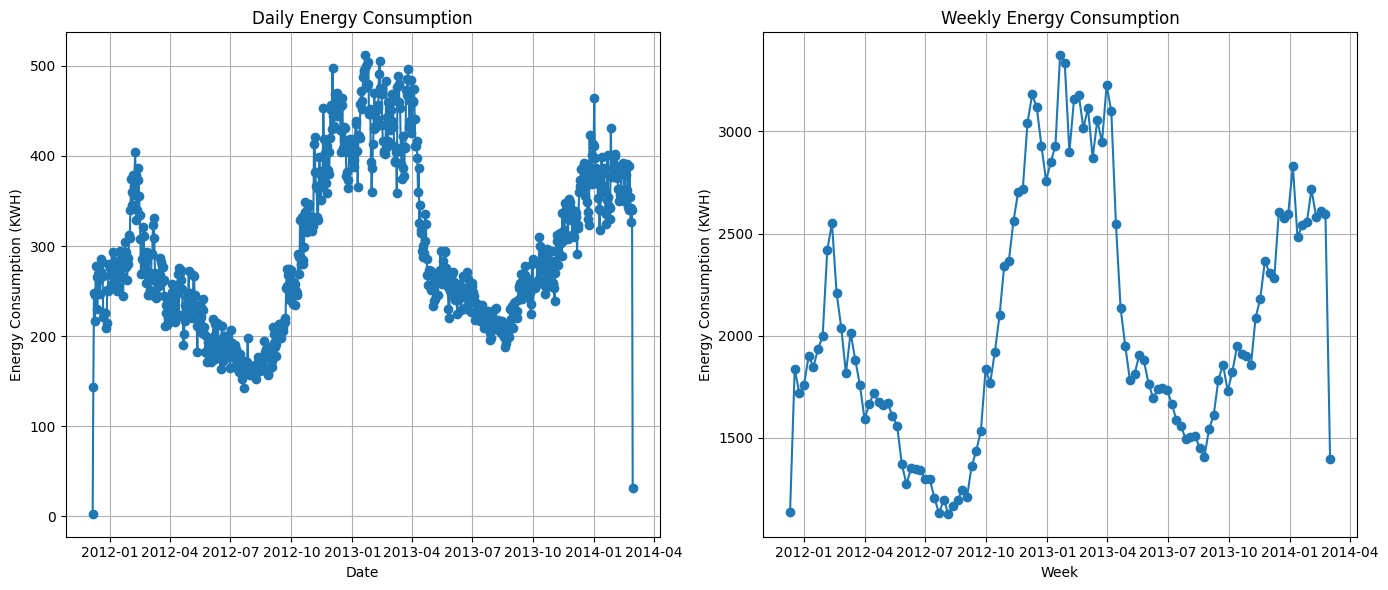

In [88]:
# Daily and Weekly energy consumption
daily_energy = LCL_df.resample('D', on='DateTime')['KWH/hh (per half hour)'].sum()
weekly_energy = LCL_df.resample('W', on='DateTime')['KWH/hh (per half hour)'].sum()

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(daily_energy.index, daily_energy.values, marker='o', linestyle='-')
plt.title('Daily Energy Consumption')
plt.xlabel('Date')
plt.ylabel('Energy Consumption (KWH)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(weekly_energy.index, weekly_energy.values, marker='o', linestyle='-')
plt.title('Weekly Energy Consumption')
plt.xlabel('Week')
plt.ylabel('Energy Consumption (KWH)')
plt.grid(True)

plt.tight_layout()
plt.show()


In [92]:
LCL_df

,LCLid,stdorToU,DateTime,KWH/hh (per half hour),stdorToU_encoded,Day,Month,Season,is_weekend,is_holiday,is_working_day
0,MAC000002,Std,2012-10-12 00:30:00,0.000,0,12,10,Autumn,False,False,True
1,MAC000002,Std,2012-10-12 01:00:00,0.000,0,12,10,Autumn,False,False,True
2,MAC000002,Std,2012-10-12 01:30:00,0.000,0,12,10,Autumn,False,False,True
3,MAC000002,Std,2012-10-12 02:00:00,0.000,0,12,10,Autumn,False,False,True
4,MAC000002,Std,2012-10-12 02:30:00,0.000,0,12,10,Autumn,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...
999995,MAC000036,Std,2012-11-08 08:00:00,0.228,0,8,11,Autumn,False,False,True
999996,MAC000036,Std,2012-11-08 08:30:00,0.042,0,8,11,Autumn,False,False,True
999997,MAC000036,Std,2012-11-08 09:00:00,0.076,0,8,11,Autumn,False,False,True
999998,MAC000036,Std,2012-11-08 09:30:00,0.070,0,8,11,Autumn,False,False,True


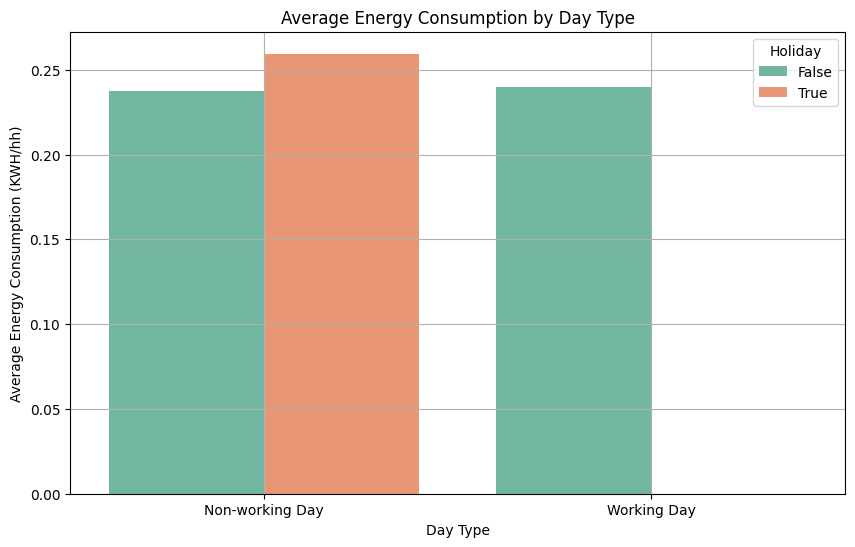

In [100]:
# Calculate average energy consumption by day type
avg_energy_by_day = LCL_df.groupby(['is_working_day', 'is_holiday'])['KWH/hh (per half hour)'].mean().reset_index()

# Plot bar chart of average energy consumption by day type
plt.figure(figsize=(10, 6))
sns.barplot(x='is_working_day', y='KWH/hh (per half hour)', hue='is_holiday', data=avg_energy_by_day, palette='Set2')
plt.title('Average Energy Consumption by Day Type')
plt.xlabel('Day Type')
plt.ylabel('Average Energy Consumption (KWH/hh)')
plt.xticks([0, 1], ['Non-working Day', 'Working Day'])
plt.legend(title='Holiday')
plt.grid(True)
plt.show()


## Daily Dataframe

In [112]:
# Creating the daily DataFrame
daily_df = LCL_df.resample('D', on='DateTime').agg({
    'KWH/hh (per half hour)': 'sum',
    'is_weekend': 'first',
    'is_holiday': 'first',
    'is_working_day': 'first'
}).reset_index()

daily_df['Day'] = daily_df['DateTime'].dt.day
daily_df['Month'] = daily_df['DateTime'].dt.month
daily_df['Season'] = daily_df['DateTime'].apply(lambda x: (x.month%12 + 3)//3)
daily_df['Season'] = daily_df['Season'].map({1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Autumn'})

# Renaming columns for clarity
daily_df.columns = ['Date', 'Daily_KWH', 'is_weekend', 'is_holiday', 'is_working_day', 'Day', 'Month', 'Season']


In [113]:
daily_df

,Date,Daily_KWH,is_weekend,is_holiday,is_working_day,Day,Month,Season
0,2011-12-06,2.947,False,False,True,6,12,Winter
1,2011-12-07,143.160,False,False,True,7,12,Winter
2,2011-12-08,248.374,False,False,True,8,12,Winter
3,2011-12-09,216.327,False,False,True,9,12,Winter
4,2011-12-10,246.168,True,False,False,10,12,Winter
...,...,...,...,...,...,...,...,...
811,2014-02-24,354.446,False,False,True,24,2,Winter
812,2014-02-25,326.796,False,False,True,25,2,Winter
813,2014-02-26,342.405,False,False,True,26,2,Winter
814,2014-02-27,340.142,False,False,True,27,2,Winter


## Ecode Daily DF

In [116]:
# Create a copy of daily_df to avoid changing the original DataFrame
daily_df_encoded = daily_df.copy()

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Encode the 'Season' column
daily_df_encoded['Season_encoded'] = label_encoder.fit_transform(daily_df_encoded['Season'])

# Convert boolean columns to integers
daily_df_encoded['is_weekend'] = daily_df_encoded['is_weekend'].astype(int)
daily_df_encoded['is_holiday'] = daily_df_encoded['is_holiday'].astype(int)
daily_df_encoded['is_working_day'] = daily_df_encoded['is_working_day'].astype(int)

# Drop the original 'Season' column
daily_df_encoded.drop(columns=['Season'], inplace=True)

In [117]:
daily_df_encoded

,Date,Daily_KWH,is_weekend,is_holiday,is_working_day,Day,Month,Season_encoded
0,2011-12-06,2.947,0,0,1,6,12,3
1,2011-12-07,143.160,0,0,1,7,12,3
2,2011-12-08,248.374,0,0,1,8,12,3
3,2011-12-09,216.327,0,0,1,9,12,3
4,2011-12-10,246.168,1,0,0,10,12,3
...,...,...,...,...,...,...,...,...
811,2014-02-24,354.446,0,0,1,24,2,3
812,2014-02-25,326.796,0,0,1,25,2,3
813,2014-02-26,342.405,0,0,1,26,2,3
814,2014-02-27,340.142,0,0,1,27,2,3


## Weekly DF

In [108]:
# Creating the weekly DataFrame
weekly_df = LCL_df.resample('W-Mon', on='DateTime').agg({
    'KWH/hh (per half hour)': 'sum',
    'is_weekend': 'first',
    'is_holiday': 'first',
    'is_working_day': 'first'
}).reset_index()

weekly_df['Week'] = weekly_df['DateTime'].dt.isocalendar().week
weekly_df['Season'] = weekly_df['DateTime'].apply(lambda x: (x.month%12 + 3)//3)
weekly_df['Season'] = weekly_df['Season'].map({1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Autumn'})

# Renaming columns for clarity
weekly_df.columns = ['DateTime', 'Weekly_KWH', 'is_weekend', 'is_holiday', 'is_working_day', 'Week', 'Season']


In [109]:
weekly_df

,DateTime,Weekly_KWH,is_weekend,is_holiday,is_working_day,Week,Season
0,2011-12-12,1400.667000,False,False,True,50,Winter
1,2011-12-19,1843.064000,False,False,True,51,Winter
2,2011-12-26,1655.615999,False,False,True,52,Winter
3,2012-01-02,1819.392001,False,True,False,1,Winter
4,2012-01-09,1903.629000,False,False,True,2,Winter
...,...,...,...,...,...,...,...
112,2014-02-03,2727.381002,False,False,True,6,Winter
113,2014-02-10,2547.021998,False,False,True,7,Winter
114,2014-02-17,2647.097002,False,False,True,8,Winter
115,2014-02-24,2558.160998,False,False,True,9,Winter


## Weekly DF Ecoding

In [114]:
# Create a copy of weekly_df to avoid changing the original DataFrame
weekly_df_encoded = weekly_df.copy()

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Encode the 'Season' column
weekly_df_encoded['Season_encoded'] = label_encoder.fit_transform(weekly_df_encoded['Season'])

# Convert boolean columns to integers
weekly_df_encoded['is_weekend'] = weekly_df_encoded['is_weekend'].astype(int)
weekly_df_encoded['is_holiday'] = weekly_df_encoded['is_holiday'].astype(int)
weekly_df_encoded['is_working_day'] = weekly_df_encoded['is_working_day'].astype(int)

# Drop the original 'Season' column
weekly_df_encoded.drop(columns=['Season'], inplace=True)

In [115]:
weekly_df_encoded

,DateTime,Weekly_KWH,is_weekend,is_holiday,is_working_day,Week,Season_encoded
0,2011-12-12,1400.667000,0,0,1,50,3
1,2011-12-19,1843.064000,0,0,1,51,3
2,2011-12-26,1655.615999,0,0,1,52,3
3,2012-01-02,1819.392001,0,1,0,1,3
4,2012-01-09,1903.629000,0,0,1,2,3
...,...,...,...,...,...,...,...
112,2014-02-03,2727.381002,0,0,1,6,3
113,2014-02-10,2547.021998,0,0,1,7,3
114,2014-02-17,2647.097002,0,0,1,8,3
115,2014-02-24,2558.160998,0,0,1,9,3


## Model Training

## Check for Stationarity

In [200]:
# Check for Stationarity Again
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print(f'Critical Value ({key}): {value}')
    if result[1] > 0.05:
        print("Data is not stationary")
    else:
        print("Data is stationary")

## Grid Search

In [201]:
# Suppress warnings
warnings.filterwarnings('ignore')

# Function to perform grid search
def grid_search_arima(data, p_values, d_values, q_values):
    best_aic = np.inf
    best_order = None
    best_model = None

    for p, d, q in itertools.product(p_values, d_values, q_values):
        try:
            model = ARIMA(data, order=(p, d, q))
            model_fit = model.fit()
            aic = model_fit.aic
            if aic < best_aic:
                best_aic = aic
                best_order = (p, d, q)
                best_model = model_fit
        except:
            continue

    return best_order, best_model

## DAILY DF

In [202]:
adf_test(daily_df_encoded['Daily_KWH'])

ADF Statistic: -1.8392426964656832
p-value: 0.36116007664166005
Critical Value (1%): -3.4386126789104074
Critical Value (5%): -2.865186972298872
Critical Value (10%): -2.5687119871327146
Data is not stationary


In [203]:
# Make the Data Stationary
data_diff = daily_df_encoded['Daily_KWH'].diff().dropna()
adf_test(data_diff)

ADF Statistic: -4.704034006218562
p-value: 8.269659955471604e-05
Critical Value (1%): -3.438623132449471
Critical Value (5%): -2.8651915799370014
Critical Value (10%): -2.568714441670417
Data is stationary


In [204]:
# Grid search for best p, d, q values
p_values = range(0, 6)
d_values = range(0, 3)
q_values = range(0, 6)
best_order, best_model = grid_search_arima(data_diff, p_values, d_values, q_values)

In [205]:
print('Best ARIMA order:', best_order)
print(best_model.summary())

Best ARIMA order: (5, 0, 3)
                               SARIMAX Results                                
Dep. Variable:              Daily_KWH   No. Observations:                  815
Model:                 ARIMA(5, 0, 3)   Log Likelihood               -3737.971
Date:                Sun, 07 Jul 2024   AIC                           7495.943
Time:                        11:23:56   BIC                           7542.974
Sample:                    12-07-2011   HQIC                          7513.994
                         - 02-28-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0691      0.478      0.145      0.885      -0.867       1.005
ar.L1          0.1745      0.101      1.729      0.084      -0.023       0.372
ar.L2         -0.7092   

In [206]:
split_point = int(len(data_diff) * 0.8)
train_daily = data_diff[:split_point]
test_daily = data_diff[split_point:]

In [207]:
# Fit ARIMA model on training data
daily_model = ARIMA(train_daily, order=(5, 0, 3))
model_fit_daily = daily_model.fit()

# Forecast future values
forecast_steps = len(test_daily)
forecast = model_fit_daily.forecast(steps=forecast_steps)


## Visualize Forecasted Values

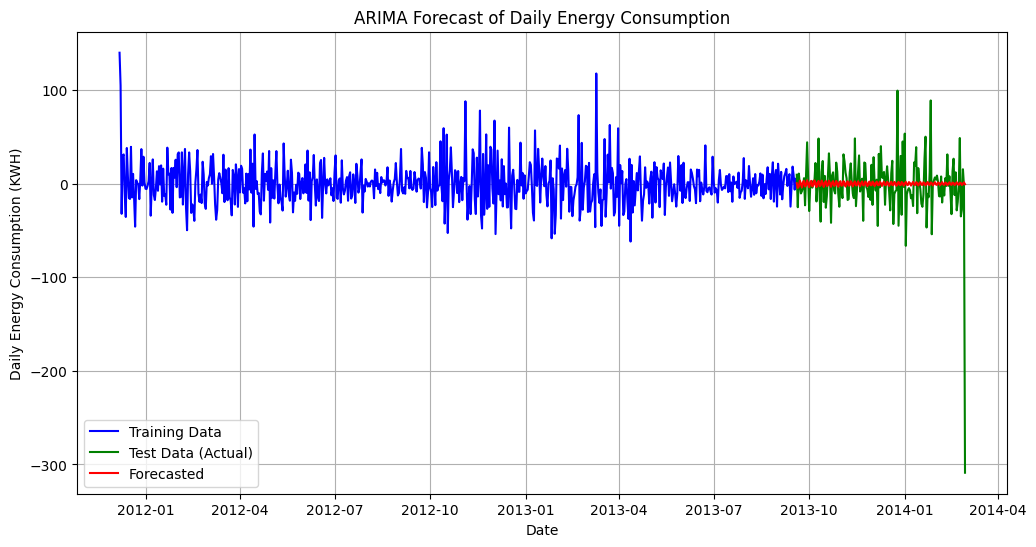

In [208]:
# Plotting actual vs forecasted values
plt.figure(figsize=(12, 6))
plt.plot(train_daily.index, train_daily, label='Training Data', color='blue')
plt.plot(test_daily.index, test_daily, label='Test Data (Actual)', color='green')
plt.plot(test_daily.index, forecast, label='Forecasted', color='red')
plt.title('ARIMA Forecast of Daily Energy Consumption')
plt.xlabel('Date')
plt.ylabel('Daily Energy Consumption (KWH)')
plt.legend()
plt.grid(True)
plt.show()

In [209]:
mse = mean_squared_error(test_daily, forecast)

mae = np.mean(np.abs(forecast - test_daily))

mape = np.mean(np.abs((forecast - test_daily) / test_daily)) * 100

rmse = mean_squared_error(test_daily, forecast, squared=False)


print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Squared Error (MSE): 1148.6129339278914
Mean Absolute Error (MAE): 19.291205079319734
Mean Absolute Percentage Error (MAPE): 160.95%
Root Mean Squared Error (RMSE): 33.8911925716386


## WEEKLY DF

In [181]:
weekly_df_encoded

,DateTime,Weekly_KWH,is_weekend,is_holiday,is_working_day,Week,Season_encoded
0,2011-12-12,1400.667000,0,0,1,50,3
1,2011-12-19,1843.064000,0,0,1,51,3
2,2011-12-26,1655.615999,0,0,1,52,3
3,2012-01-02,1819.392001,0,1,0,1,3
4,2012-01-09,1903.629000,0,0,1,2,3
...,...,...,...,...,...,...,...
112,2014-02-03,2727.381002,0,0,1,6,3
113,2014-02-10,2547.021998,0,0,1,7,3
114,2014-02-17,2647.097002,0,0,1,8,3
115,2014-02-24,2558.160998,0,0,1,9,3


In [210]:
adf_test(weekly_df_encoded['Weekly_KWH'])

ADF Statistic: -2.786603935160775
p-value: 0.06021292593244985
Critical Value (1%): -3.4936021509366793
Critical Value (5%): -2.8892174239808703
Critical Value (10%): -2.58153320754717
Data is not stationary


In [211]:
# Make the Data Stationary
data_diff = weekly_df_encoded['Weekly_KWH'].diff().dropna()
data_diff2 = data_diff.diff().dropna()
adf_test(data_diff2)

ADF Statistic: -4.477572342297505
p-value: 0.00021582602651357686
Critical Value (1%): -3.4936021509366793
Critical Value (5%): -2.8892174239808703
Critical Value (10%): -2.58153320754717
Data is stationary


In [212]:
# Grid search for best p, d, q values
p_values = range(0, 6)
d_values = range(0, 3)
q_values = range(0, 6)
best_order, best_model = grid_search_arima(data_diff2, p_values, d_values, q_values)

In [188]:
print('Best ARIMA order:', best_order)
print(best_model.summary())

Best ARIMA order: (2, 1, 4)
                               SARIMAX Results                                
Dep. Variable:             Weekly_KWH   No. Observations:                  115
Model:                 ARIMA(2, 1, 4)   Log Likelihood                -772.680
Date:                Sun, 07 Jul 2024   AIC                           1559.360
Time:                        11:10:27   BIC                           1578.514
Sample:                             0   HQIC                          1567.133
                                - 115                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5818      0.095    -16.638      0.000      -1.768      -1.396
ar.L2         -0.8341      0.090     -9.284      0.000      -1.010      -0.658
ma.L1         -0.1001   

In [213]:
split_point = int(len(data_diff) * 0.8)
train_weekly = data_diff2[:split_point]
test_weekly = data_diff2[split_point:]

In [214]:
# Fit ARIMA model on training data
weekly_model = ARIMA(train, order=(2, 1, 4))
weekly_model_fit = weekly_model.fit()

# Forecast future values
forecast_steps = len(test)
forecast_weekly = weekly_model_fit.forecast(steps=forecast_steps)


## Visualize Forecasted Values

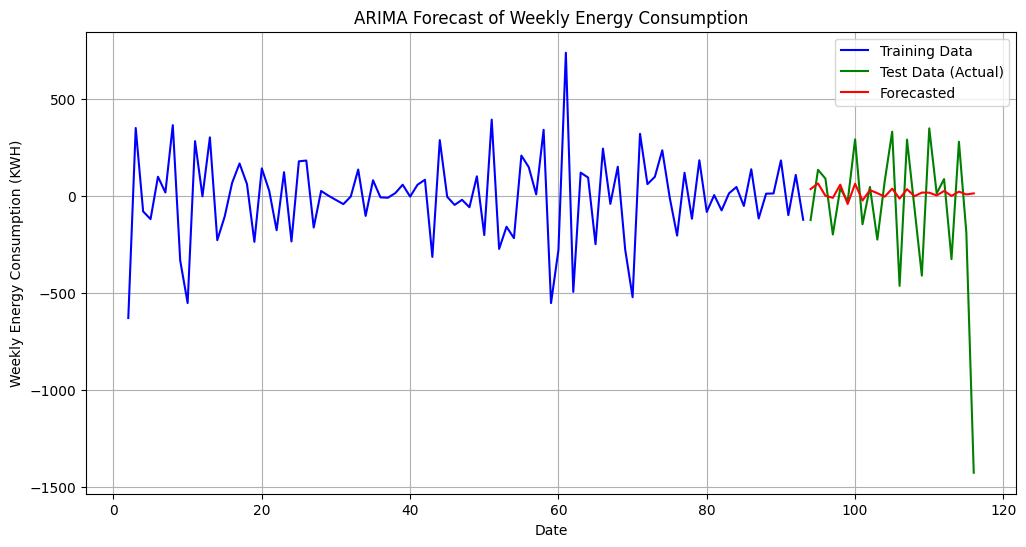

In [217]:
# Plotting actual vs forecasted values
plt.figure(figsize=(12, 6))
plt.plot(train_weekly.index, train_weekly, label='Training Data', color='blue')
plt.plot(test_weekly.index, test_weekly, label='Test Data (Actual)', color='green')
plt.plot(test_weekly.index, forecast_weekly, label='Forecasted', color='red')
plt.title('ARIMA Forecast of Weekly Energy Consumption')
plt.xlabel('Date')
plt.ylabel('Weekly Energy Consumption (KWH)')
plt.legend()
plt.grid(True)
plt.show()

In [218]:
mse = mean_squared_error(test_weekly, forecast_weekly)

mae = np.mean(np.abs(forecast_weekly - test_weekly))

mape = np.mean(np.abs((forecast_weekly - test_weekly) / test_weekly)) * 100

rmse = mean_squared_error(test_weekly, forecast_weekly, squared=False)


print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Squared Error (MSE): 137192.70712788525
Mean Absolute Error (MAE): 182.8934330058116
Mean Absolute Percentage Error (MAPE): 90.94%
Root Mean Squared Error (RMSE): 370.3953389661987
